In [51]:
### NOTE: 
### Before running this: 
### 1) run git clone https://github.com/jannisborn/covid19_pocus_ultrasound.git in main folder
### 2) run python /scripts python3 scripts/cross_val_splitter.py --splits 5 to get training/validation split. 

### Because of the relatively small size of the dataset, the authors recommend cross-validation. We can either
### go with this or set up our own train/val split. Right now I just use the first fold and do 80/20 train/val
### for simplicity.


### This notebook inputs data, sets up training process, and uses a simple 2-layer CNN as a jank baseline
### I currently just do 3-class prediction because it turns out bacterial pheumonia is like
### surprisingly different from viral pheumonia 
### but changing baseline to 2-class and retraining is super easy 

### Notes about the project:

### https://docs.google.com/spreadsheets/d/1t-tLMjMod6W-nAjkuxmO0CLsiyalFIOp92k_XD_yeo8/edit#gid=1181682638
### ^^^ all the information about where the ultrasound videos came from, alongside notes taken by 
### MDs about each dataset. Most of the data is available here and will be used in our project ^^

### All images were taken using convex ultrasound probes -- which is great since they offer the best quality
### for lung ultrasound (LUS) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4098927/. 
### Generally more affected by lack of specificity than lack of sensitivity. Raw images all in 
### data/pocus_images/Convex. It seems like they take 5-6 images from each video -- and
### tbh images don't change that much during ultrasound so effectively
### a lot of the images are duplicates, which I think should be fine 

### Other possible sources of images: 1) COVID-19 ultrasound_gallery from Butterfly
### which we can download here: https://butterflynetwork.com/covid19/covid-19-ultrasound-gallery.
### original repo used this one

### 2) Mew ultrasound data (like, 5/16 new) available from The ICLUS project here https://www.disi.unitn.it/iclus
### which has 60 more patients' of data, if we want to be reaaaally state of the art. 
### I requested an account for access in case we need more novelty lol. Surprisingly they
### approved it within like 3 hours, no questions asked -- go italy

import os
import numpy as np
import cv2
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from scipy import stats
import pickle
import pandas as pd
import seaborn as sn

from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score

DATA_DIR = 'covid19_pocus_ultrasound/data/cross_validation'
MODEL_DIR = 'covid19_pocus_ultrasound/models'

### Note: This is what the authors resized images to, we can play with this (or change it)
### all depends on what resolution our pretrained model uses 

IMG_WIDTH = 224
IMG_HEIGHT = 224


### This is which "fold" of the cross validation. Rn I just set this as the first one so we do normal
### 80/20 train/val split, but we can iterate over this for robust n-fold validation
FOLD = 0

In [52]:
### Data for getting images from https://github.com/jrosebr1/imutils/blob/master/imutils/paths.py
image_types = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")

def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=image_types, contains=contains)


def list_files(basePath, validExts=None, contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if validExts is None or ext.endswith(validExts):
                # construct the path to the image and yield it
                imagePath = os.path.join(rootDir, filename)
                yield imagePath

In [53]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print('Loading images...')
imagePaths = list(list_images(DATA_DIR))

train_labels, test_labels = [], []
train_data, test_data = [], []

print(imagePaths[0:5])

Loading images...
['covid19_pocus_ultrasound/data/cross_validation/split0/covid/Cov-Atlas+(44).gif_frame0.jpg', 'covid19_pocus_ultrasound/data/cross_validation/split0/covid/Cov-Atlas+(44).gif_frame12.jpg', 'covid19_pocus_ultrasound/data/cross_validation/split0/covid/Cov-Atlas+(44).gif_frame15.jpg', 'covid19_pocus_ultrasound/data/cross_validation/split0/covid/Cov-Atlas+(44).gif_frame18.jpg', 'covid19_pocus_ultrasound/data/cross_validation/split0/covid/Cov-Atlas+(44).gif_frame21.jpg']


In [54]:

# loop over folds
for imagePath in imagePaths:

    path_parts = imagePath.split(os.path.sep)
    
    # extract the split
    train_test = path_parts[-3][-1]
    
    # extract the class label from the filename
    label = path_parts[-2]
    
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))

    # update the data and labels lists, respectively
    if train_test == str(FOLD):
        test_labels.append(label)
        test_data.append(image)
    else:
        train_labels.append(label)
        train_data.append(image)

# Prepare data for model
print(
    f'\nNumber of training samples: {len(train_labels)} \n'
    f'Number of validation samples: {len(test_labels)}'
)



Number of training samples: 701 
Number of validation samples: 210


In [55]:
### Tbh... why are there 3 channels lol isn't ultrasound all gray anyway
print(train_data[0].shape)

(224, 224, 3)


In [94]:
from collections import Counter

### ok so these are all strings.. great
print(Counter(train_labels).keys())
print(Counter(train_labels).values())

dict_keys(['covid', 'pneumonia', 'regular'])
dict_values([287, 219, 195])


In [95]:
### We define a mapping of labels from strings to ints

from sklearn import preprocessing
labEncoder = preprocessing.LabelEncoder()

labEncoder.fit(np.unique(train_labels))

train_num_labels = labEncoder.transform(train_labels)
test_num_labels = labEncoder.transform(test_labels)

In [119]:
### BASELINE

### Simple 2-layer convnet
### Modified from: https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, Sigmoid
from torch.optim import Adam, SGD


class BaselineConvNet(Module):   
    def __init__(self):
        super(BaselineConvNet, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer
            Conv2d(4, 2, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(2),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
        )
        ### Linear layers
        self.linear_layers = Sequential(
            Linear(6272, 100),
            ReLU(inplace=True),
            ### We have 3 classes but authors recommend adding a 4th class for "unrelated"
            ### where they make sure if you input like a cat the classifier doesn't say "healthy lung" or whatever
            ### ... maybe something to talk about in future work lol
            Linear(100, 3),
            ### No need to add sigmoid because pytorch crossentropyloss apparently includes softmax already
            #Sigmoid()
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [120]:
# defining the model
model = BaselineConvNet()

# defining the optimizer -- I add some random number for regularization because it makes me feel like I paid
# attention in 229
optimizer = Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

# defining the loss function
criterion = CrossEntropyLoss()
    
print(model)

BaselineConvNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=6272, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)


In [110]:
### Training with early stopping. Stochastic gradient descent with forced class balance

def train(epoch, patience, last_loss_val):
    model.train()
    tr_loss = 0
    
    # clearing the gradients of the model parameters
    optimizer.zero_grad()

    ### gets 150 images, 50 from each class (forced balance for training to work)
    indsOne = np.random.choice(np.where(y_train == 0)[0],50,replace=False)
    indsTwo = np.random.choice(np.where(y_train == 1)[0],50,replace=False)
    indsThree = np.random.choice(np.where(y_train == 2)[0],50,replace=False)
    inds = np.concatenate((indsOne, indsTwo, indsThree))
    
    # prediction for training and validation set
    output_train = model(x_train[inds])
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train[inds])
    loss_val = criterion(output_val, y_val)
    
    train_losses.append(loss_train)
    val_losses.append(loss_val)
    
    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    
    ### we did not improve, mark it
    if loss_val.item() > last_loss_val:
        patience += 1
    else: 
        patience = 0
    
    # printing the train/validation loss
    print('Epoch : ',epoch+1, '\t', 'train loss :', loss_train.item(), '\t', 'val loss :', loss_val.item(), '\t', 'patience :', patience)
    
    ### make sure that we are updating our best val loss so far
    if loss_val > last_loss_val:
        return patience, last_loss_val
    else: 
        return patience, loss_val.item()

In [111]:
# getting the training set into a form that pytorch likes
x_train = torch.tensor(train_data)
y_train = torch.tensor(train_num_labels)
    
# getting the validation set into a form that pytorch likes
x_val = torch.tensor(test_data)
y_val = torch.tensor(test_num_labels)


In [112]:
# pytorch demands that color channels go right after batch size
x_train = x_train.permute(0,3,1,2)
x_val = x_val.permute(0,3,1,2)

## should be (n,3,IMG_SIZE,IMG_SIZE)
print(x_train.shape)
print(x_val.shape)

torch.Size([701, 3, 224, 224])
torch.Size([210, 3, 224, 224])


In [113]:
x_train = x_train.float()
x_val = x_val.float()

In [121]:
# defining the number of epochs (say, 100)
# takes like 15 mins to train lol

n_epochs = 100
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

last_loss_val = 1e12
patience = 0

# training the model
for epoch in range(n_epochs):
    patience, last_loss_val = train(epoch, patience, last_loss_val)
    # if validation doesn't improve within 5 episodes, we quit
    if (patience == 10):
        break

Epoch :  1 	 train loss : 1.0906435251235962 	 val loss : 1.0926320552825928 	 patience : 0
Epoch :  2 	 train loss : 1.4603352546691895 	 val loss : 1.297960877418518 	 patience : 1
Epoch :  3 	 train loss : 1.1230754852294922 	 val loss : 1.0933135747909546 	 patience : 2
Epoch :  4 	 train loss : 0.910041093826294 	 val loss : 1.397731065750122 	 patience : 3
Epoch :  5 	 train loss : 0.7218816876411438 	 val loss : 1.1737289428710938 	 patience : 4
Epoch :  6 	 train loss : 0.5804188251495361 	 val loss : 0.7424545884132385 	 patience : 0
Epoch :  7 	 train loss : 0.6057637333869934 	 val loss : 0.8268735408782959 	 patience : 1
Epoch :  8 	 train loss : 0.593451201915741 	 val loss : 0.8422118425369263 	 patience : 2
Epoch :  9 	 train loss : 0.4753052294254303 	 val loss : 0.7277544736862183 	 patience : 0
Epoch :  10 	 train loss : 0.4623847007751465 	 val loss : 0.6517413258552551 	 patience : 0
Epoch :  11 	 train loss : 0.4830838441848755 	 val loss : 0.6251416802406311 	 pat

In [122]:
from sklearn.metrics import accuracy_score

### no grad because we're just predicting
with torch.no_grad():
    output = model(x_val)
    
### gets the highest predicted class value (out of 2) for each image
softmax = torch.exp(output)
prob = list(softmax.numpy())
predictions = np.argmax(prob, axis=1)

### accuracy on validation set (80%, 3 classes -- this is... pretty good.)
accuracy_score(y_val, predictions)

0.7952380952380952

In [123]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, predictions)

array([[104,   4,   4],
       [  0,  58,   0],
       [ 35,   0,   5]])

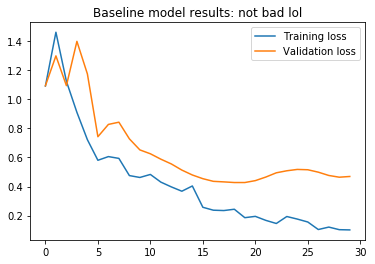

In [124]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Baseline model results: not bad lol")
plt.show()

In [125]:
labEncoder.inverse_transform([0, 1, 2])
### So it can differentiate between covid and phenomia but not covid and regular... lol it thinks
### all covid is regular this is not good

array(['covid', 'pneumonia', 'regular'], dtype='<U9')

In [109]:
### testing how concatenation works for forced class balance
print(np.where(y_train == 0)[0])
print(np.where(y_train == 1)[0])
print(np.where(y_train == 2)[0])
indsOne = np.random.choice(np.where(y_train == 0)[0],50,replace=False)
indsTwo = np.random.choice(np.where(y_train == 1)[0],50,replace=False)
indsThree = np.random.choice(np.where(y_train == 2)[0],50,replace=False)
print(indsOne)
print(indsTwo)
inds = np.concatenate((indsOne, indsTwo, indsThree))
print(inds)
    

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59 161 162 163 164 165 166 167 168 169 170 171 172
 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190
 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 341 342 343 344 345 346
 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364
 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382
 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400
 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418
 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436
 437 438 439 440 441 526 527 528 529 530 531 532 533 534 535 536 537 538
 539 540 541 542 543 544 545 546 547 548 549 550 55